In [ ]:
# import needed modules
import pandas as pd # for data analysis and manipulation
import numpy as np # for quicker array computing
import os # for os manipulation
import matplotlib.pyplot as plt # for visual plotting
from matplotlib.pyplot import imread # for image reading
import seaborn as sns # statistical data visualization
import tensorflow as tf # for model building
import tensorflow_hub as hub # for already pre-trained models
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import datetime # for working with times and dates
import seaborn as sn
import random

# set up matplotlib to work interactively
%matplotlib inline

In [ ]:
# check tensorflow and hub version
print('tensorflow:', tf.__version__)
print('hub:', hub.__version__)

tensorflow: 2.6.0
hub: 0.12.0


In [ ]:
# check if we are running this in google colab or in jupyter and save it to IN_COLAB constant variable
if 'COLAB_GPU' in os.environ:
  IN_COLAB = True
else:
  IN_COLAB = False

# print out working environment
# if we are in google colab, check if GPU is available and if so, print the name of the GPU
if IN_COLAB:
  print('You are running this in GOOGLE COLAB')
  if tf.config.list_physical_devices('GPU'):
    !nvidia-smi -L
  else:
    print('GPU is not available')
else:
  print('You are running this in JUPYTER NOOTEBOOK')

You are running this in GOOGLE COLAB
GPU 0: Tesla K80 (UUID: GPU-9bf49f9c-5535-127d-7e6d-d095c00e508d)


In [ ]:
# setup constant variables

# path to this project
PATH = '/content/drive/MyDrive/Maturita/Obhajoba/wbc-detection'
# path to the dataset
DS_PATH = PATH + '/data'

IMG_WIDTH = 224 # 320 224
IMG_HEIGHT = 224 # 240 224
BATCH_SIZE = 32
SEED = 123
EPOCHS = 25

In [ ]:
def load_and_configure_data(path=None, batch_size=32, img_width=None, img_height=None, seed=123):
  """
  Takes path to data, batch size, image shapes, seed, then loads and
  prepares data from a local directory and returns tuple of train, validation 
  dataset batches and class names
  """
  
  # load and batch training data
  train_ds = tf.keras.utils.image_dataset_from_directory(
    path, # local path to dataset
    validation_split=0.2, # 0.2 = 20%
    subset="training", # this dataset will be used for training
    seed=seed, # random seed
    image_size=(img_height, img_width), # image resolution
    batch_size=batch_size, # size of batches data will be split to
    shuffle=True,
    label_mode='categorical'
  )

  # load and batch training data
  val_ds = tf.keras.utils.image_dataset_from_directory(
    path, # local path to dataset
    validation_split=0.2, # 0.2 = 20%
    subset="validation", # this dataset will be used for validation
    seed=seed, # random seed
    image_size=(img_height, img_width), # image resolution
    batch_size=batch_size, # size of batches data will be split to
    shuffle=True,
    label_mode='categorical'
  )

  # take and split 25% of the validation data (5% of the whole dataset) and save it for testing
  print("Taking 25% of validation data for testing")
  test_ds_batch_amount = int(len(val_ds) * 0.25)

  test_ds = val_ds.take(test_ds_batch_amount) 
  val_ds = val_ds.skip(test_ds_batch_amount)
  

  # get class names before prefetching
  class_names = train_ds.class_names

  # prompt the tf.data runtime to tune the value dynamically at runtime.
  # (we do this so we dont have to manualy set number of of elements to prefetch)
  AUTOTUNE = tf.data.AUTOTUNE

  # cache- keeps the images in memory after they're loaded off disk during the first epoch
  # prefetch - overlaps data preprocessing and model execution while training.
  train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
  test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

  return train_ds, val_ds, test_ds, class_names

In [ ]:
# use the 
train_ds, val_ds, test_ds, class_names = load_and_configure_data(DS_PATH, BATCH_SIZE, IMG_WIDTH, IMG_HEIGHT, SEED)

print(f'\nclass names = {class_names}\n')
train_ds, val_ds

Found 12436 files belonging to 4 classes.
Using 9949 files for training.
Found 12436 files belonging to 4 classes.
Using 2487 files for validation.
Taking 25% of validation data for testing

class names = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']



(<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 4)), types: (tf.float32, tf.float32)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 4)), types: (tf.float32, tf.float32)>)

In [ ]:
len(train_ds), len(val_ds), len(test_ds)

(311, 59, 19)

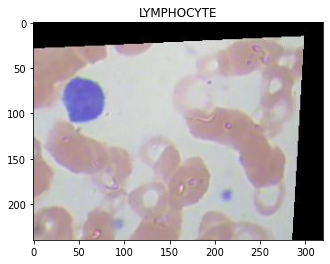

In [ ]:
def show_image_from_dir(path, class_name, index):
  """
  Takes path, class_name, index of an image and plots
  out the image and title
  """
  # get image name
  image_name = os.listdir(f'{path}/{class_name}')[index]
  # path to an image
  image_path = f'{path}/{class_name}/{image_name}'

  # plot an image with title
  imgplot = plt.imshow(imread(image_path))
  plt.title(class_name)
  
show_image_from_dir(DS_PATH, class_names[1], 4)

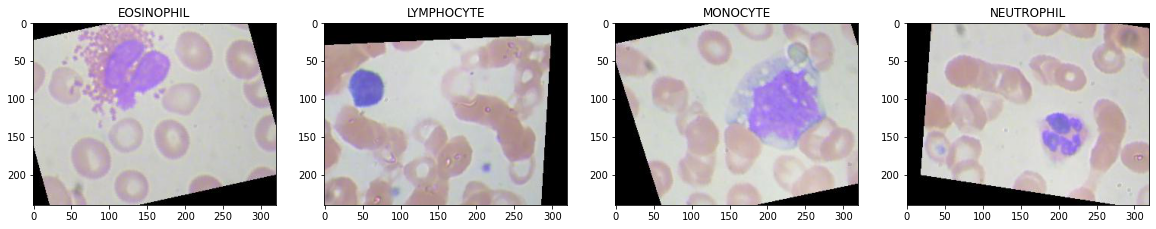

In [ ]:
def show_image_per_class_from_dir(path, class_names, index):
  """
  Takes path, class_names, index and returns
  4 plotted images, one from each class
  """
  # create subplots with 1 row and 4 columns with 20x15 size
  f, axarr = plt.subplots(1,4, figsize=(20,20))

  # loops through each class
  for i in range(len(class_names)):
    # get current class name
    class_name = class_names[i]

    # get image name and path
    image_name = os.listdir(f'{path}/{class_name}')[index]
    image_path = f'{path}/{class_name}/{image_name}'

    # plot an image with title
    axarr[i].imshow(imread(image_path))
    axarr[i].title.set_text(class_names[i])


show_image_per_class_from_dir(DS_PATH, class_names, 4)

In [ ]:
def configure_and_normalize_dataset(train_ds, val_ds):
  normalization_layer = tf.keras.layers.Rescaling(1./255)

  normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
  normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

  return normalized_train_ds, normalized_val_ds

  #image_batch, labels_batch = next(iter(normalized_ds))
  #first_image = image_batch[0]
  # Notice the pixel values are now in `[0,1]`.
  #print(np.min(first_image), np.max(first_image))

configure_and_normalize_dataset(train_ds, val_ds)

(<MapDataset shapes: ((None, 224, 224, 3), (None, 4)), types: (tf.float32, tf.float32)>,
 <MapDataset shapes: ((None, 224, 224, 3), (None, 4)), types: (tf.float32, tf.float32)>)

In [ ]:
def create_model(img_height, img_width, class_names):
  """
  function that takes image sizes, class names and returns
  CNN model ready to be compiled and trained
  """
  random.seed(SEED)

  resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(img_height, img_width),
    tf.keras.layers.Rescaling(1./255)
  ])

  data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
  ])

  model = tf.keras.Sequential([

    # 1st CNN layer (input layer)
    resize_and_rescale,
    data_augmentation,
    tf.keras.layers.Conv2D(16, 3, activation="relu", input_shape=(IMG_HEIGHT, IMG_WIDTH)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.BatchNormalization(),

    # 2nd CNN layer
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(128, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    # 3rd CNN layer
    tf.keras.layers.Conv2D(256, 3 ,activation="relu"),
    tf.keras.layers.GlobalMaxPooling2D(),

    # 5th CNN layer
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.4),

    # 6th CNN layer
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.3),

    # 6th CNN layer
    tf.keras.layers.Dense(32, activation="relu"),

    # 7th CNN layer (output layer)
    tf.keras.layers.Dense(len(class_names),activation="softmax")
  ])

  """
    model = tf.keras.Sequential([

      # 1st CNN layer (input layer)
      resize_and_rescale,
      data_augmentation,
      tf.keras.layers.Conv2D(16, 3, activation="relu", input_shape=(IMG_HEIGHT, IMG_WIDTH)),
      tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
      tf.keras.layers.BatchNormalization(),

      # 2nd CNN layer
      tf.keras.layers.Conv2D(32, 3, activation="relu", input_shape=(IMG_HEIGHT, IMG_WIDTH)),
      tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

      # 3rd CNN layer
      tf.keras.layers.Conv2D(64, 3 ,activation="relu"),
      tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

      # 4th CNN layer
      tf.keras.layers.Conv2D(128, 3, activation="relu"),
      #tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
      tf.keras.layers.GlobalMaxPooling2D(),

      # 5th CNN layer
      tf.keras.layers.Dense(128, activation="relu"),
      tf.keras.layers.Dropout(0.5),

      # 6th CNN layer
      tf.keras.layers.Dense(64, activation="relu"),
      tf.keras.layers.Dropout(0.25),

      # 6th CNN layer
      tf.keras.layers.Dense(32, activation="relu"),

      # 7th CNN layer (output layer)
      tf.keras.layers.Dense(len(class_names),activation="softmax")
    ])
  """

  return model

model = create_model(IMG_HEIGHT, IMG_WIDTH, class_names)

In [ ]:
def compile_and_train(model, train_ds, val_ds, img_width, img_height, epochs=100):
  """
  function that takes uncompiled model, training and validation data, image shapes 
  and number of epochs and returns trained model with train history of the model
  """
  random.seed(SEED)

  # compile model with adam as optimizer
  model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

  # build model and summarize the model
  model.build([None, img_width, img_height, 3])
  model.summary()

  # prompt user to type y or Y so the training wont start instantly
  inp = input('\nAre you happy with this model and do you want to proceed to train (y) ? ')
  print('\n')

  if inp == 'y' or inp == 'Y':
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)

    history = model.fit(train_ds, 
                        validation_data=val_ds, 
                        epochs=epochs, 
                        callbacks=[early_stopping], 
                        validation_freq=1)

    model.save('/content/drive/MyDrive/Maturita/Obhajoba/wbc-detection/test_model.h5')

    return model, history

In [ ]:
# model = tf.keras.models.load_model('/content/drive/MyDrive/Maturita/Obhajoba/wbc-detection/test_model.h5')

In [ ]:
model, train_history = compile_and_train(model, train_ds, val_ds, IMG_WIDTH, IMG_HEIGHT, epochs=EPOCHS)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 111, 111, 16)      64        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 32)       

In [ ]:
def show_train_history(train_history, epochs):
  """
  function that takes train history data and number of epochs
  and visualizes the training process
  """
  
  acc = train_history.history['accuracy']
  val_acc = train_history.history['val_accuracy']

  loss = train_history.history['loss']
  val_loss = train_history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

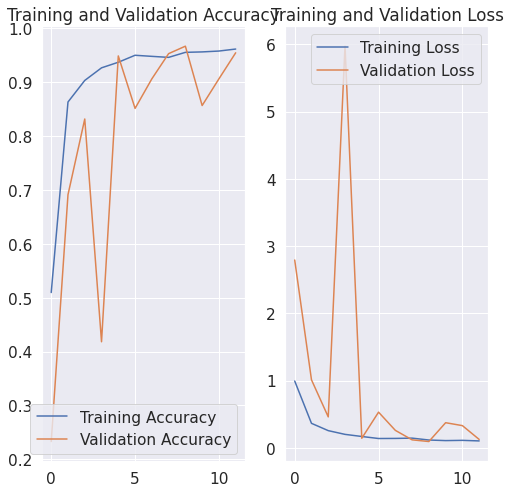

In [ ]:
show_train_history(train_history, 12)

In [ ]:
def prediction_from_path(model, path):
  img = tf.keras.utils.load_img(
      path, target_size=(IMG_HEIGHT, IMG_WIDTH)
  )

  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  max_index = np.argmax(predictions[0])
  print(class_names[max_index], predictions[0][max_index] * 100)

prediction_from_path(model, '/content/drive/MyDrive/Maturita/Obhajoba/wbc-detection/manual_test/LYMPHOCYTE/_5_1558.jpeg')

LYMPHOCYTE 100.0


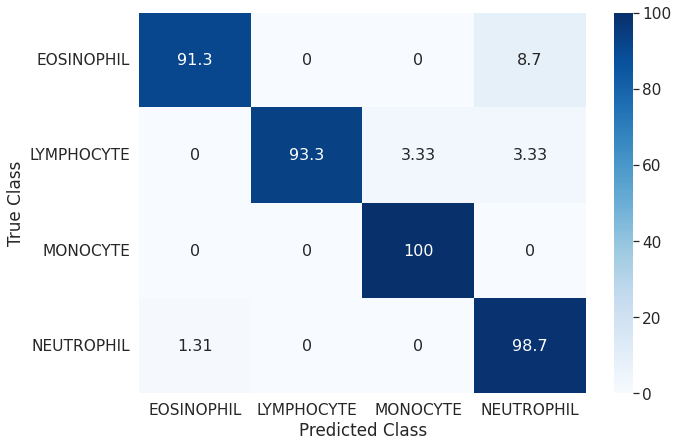

In [ ]:
def plot_confusion_matrix(mode, test_ds, class_names):
  test_ds_imgs = tf.concat([x for x, y in test_ds], axis=0)
  y_pred = model.predict(test_ds_imgs)

  predicted_categories = tf.argmax(y_pred, axis=1)
  true_categories = tf.concat([y for x, y in test_ds], axis=0)
  true_categories = tf.concat([np.argmax(x) for x in true_categories], axis=0)

  cm = confusion_matrix(predicted_categories, true_categories)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

  df_cm = pd.DataFrame(cm, class_names, class_names)
  plt.figure(figsize=(10,7))
  sn.set(font_scale=1.4) # for label size
  sn.heatmap(df_cm, annot=True, annot_kws={'size': 16}, fmt='.3g', cmap='Blues') # font size

  plt.xlabel("Predicted Class")
  plt.ylabel("True Class")

  plt.show()

plot_confusion_matrix(model, test_ds, class_names)

In [ ]:
# get the ground truth of your data. 
test_ds_imgs = tf.concat([x for x, y in test_ds], axis=0)
true_categories = tf.concat([y for x, y in test_ds], axis=0)
true_categories = tf.concat([np.argmax(x) for x in true_categories], axis=0)
test_labels=true_categories

# predict the probability distribution of the data
predictions=model.predict_generator(test_ds_imgs, steps=28, verbose=0)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the classification report
print(classification_report(true_categories, y_pred))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


              precision    recall  f1-score   support

           0       0.91      0.98      0.95       128
           1       0.93      1.00      0.97       168
           2       1.00      0.96      0.98       143
           3       0.99      0.89      0.94       169

    accuracy                           0.96       608
   macro avg       0.96      0.96      0.96       608
weighted avg       0.96      0.96      0.96       608

